<a href="https://colab.research.google.com/github/aadyasingh55/PredictiveMaintenance/blob/main/Copy_of_Deep_Learning_with_PyTorch_Object_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro Task, Object Localization

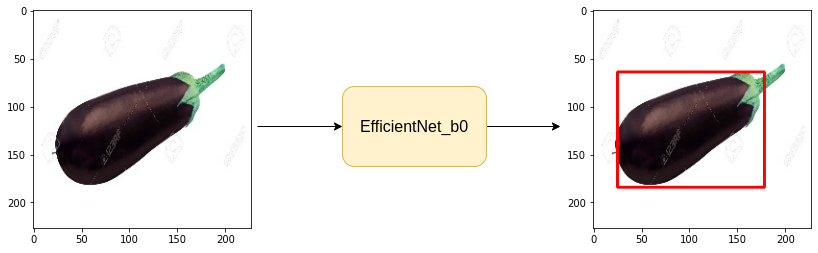

In [ ]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-ygmyx2ws
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-ygmyx2ws
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.1-py3-none-any.whl size=125700 sha256=9d57fd907f2f7abb4cdce6b1188ba26273295242477b489a0f0f18978dbd63e8
  Stored in directory: /tmp/pip-ephem-wheel-cache-w06cmate/wheels/51/4d/ab/5aafa8b980086fbc362946de7da4aa3df33aacb3da0da29b93
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [ ]:
# Create a copy of the specified repository and download its contents

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 28.87 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
import pandas as pd
import numpy as np
import cv2 #imports the OpenCV library,used for computer vision tasks, such as image and video processing, object detection, and image recognition.
import matplotlib.pyplot as plt
import torch #imports the OpenCV library, which stands for "Open Source Computer Vision." OpenCV is a popular library used for computer vision tasks, such as image and video processing, object detection, and image recognition.
from tqdm.notebook import tqdm #mports the tqdm library,which provides a progress bar for loops and iterations.

from sklearn.model_selection import train_test_split #This function is used to split datasets into training and testing subsets for machine learning tasks
from sklearn.preprocessing import LabelEncoder #LabelEncoder is used to convert categorical labels (strings or integers) into numerical labels,

In [ ]:
# Adding the directory path '/content/object-localization-dataset' to sys.path
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [ ]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

DEVICE = 'cuda' #It indicates that the code will use the GPU for computations.

BATCH_SIZE = 16 #It specifies the number of samples that will be processed in each batch during training.
IMG_SIZE = 140 # It represents the desired size of the input images during preprocessing or training.

LR= 0.001 #It represents the learning rate
EPOCHS = 40 #It represents the EPOCHS
MODEL_NAME = 'efficientnet_b5' #It indicates the name or identifier of a specific neural network model architecture.

NUM_COR = 4 #represents the number of coordinates (e.g., (x, y) pairs) needed to represent the bounding box for each localized object in the dataset.

In [ ]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

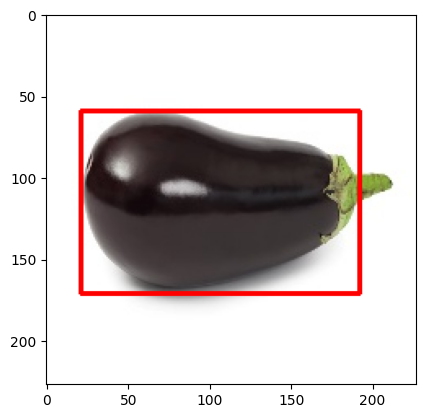

In [ ]:
row = df.iloc[184]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
pt1 = (row.xmin,row.ymin)
pt2 = (row.xmax , row.ymax)
bnd_box_img = cv2.rectangle(img,pt1, pt2, (255,0,0),2)
plt.imshow(bnd_box_img)

In [ ]:
#splitting dataset into train and validation
train_df,valid_df = train_test_split(df,test_size= 0.2, random_state = 42)

# Augmentations

In [ ]:
import albumentations as A

In [ ]:
train_augs = A.Compose([ #allows you to combine multiple image augmentation techniques into a single pipeline.
        A.Resize(IMG_SIZE,IMG_SIZE), # Images are resized to a consistent size for model training.
        A.HorizontalFlip (p=0.5), #applies horizontal flipping to the image with a probability of 0.5, which effectively creates a mirrored version of the image along the vertical axis
        A.VerticalFlip(p=0.5), #this transformation applies vertical flipping to the image with a probability of 0.5, creating a mirrored version along the horizontal axis.
        A.Rotate() #applies a random rotation to the image.
], bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

valid_augs = A.Compose([
        A.Resize(IMG_SIZE,IMG_SIZE),
], bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

# Create Custom Dataset

In [ ]:
class ObjLocDataset(torch.utils.data.Dataset):

    def __init__(self, df, augmentations = None):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self , idx):

        row = self.df.iloc[idx]

        xmin = row.xmin
        ymin = row.ymin
        xmax = row.xmax
        ymax = row.ymax

        bbox = [[xmin , ymin , xmax , ymax]]

        img_path = DATA_DIR + row.img_path
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.augmentations:
            data = self.augmentations(image = img , bboxes = bbox, class_labels = [None])
            img = data['image']
            bbox = data['bboxes'][0]

        img = torch.from_numpy(img).permute(2,0,1) / 255.0 #(h , w , c) -> (c , h , w)
        bbox = torch.Tensor(bbox)

        return img,bbox


In [ ]:
trainset =ObjLocDataset(train_df, train_augs)
validset =ObjLocDataset(valid_df, valid_augs)

In [ ]:
print(f"Total exmaples in the trainset : {len(trainset)}")
print(f"Total exmaples in the validset : {len(validset)}")

Total exmaples in the trainset : 148
Total exmaples in the validset : 38


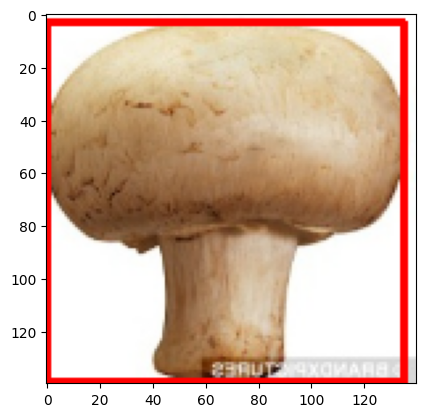

In [ ]:
img, bbox = trainset[15]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
# function from the OpenCV library used to draw rectangles on images. Here, it's being used to draw a rectangle around the specified bounding box
plt.imshow(bnd_img)

# Load dataset into batches

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset , batch_size = BATCH_SIZE, shuffle = True)
validloader = torch.utils.data.DataLoader(trainset , batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 10


In [ ]:
for images, bboxes in trainloader:
    break;

print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [ ]:
from torch import nn
import timm

In [ ]:
class ObjLocModel(nn.Module):

    def __init__(self) -> None:
        super(ObjLocModel, self).__init__()

        self.backbone = timm.create_model(MODEL_NAME , pretrained = True , num_classes = 4)


    def forward(self , images , gt_bboxes= None):

        bboxes = self.backbone(images)

        if gt_bboxes != None :
            loss = nn.MSELoss()(bboxes, gt_bboxes)
            return bboxes,loss

        return bboxes


In [ ]:
model = ObjLocModel()
model.to(DEVICE);

In [ ]:
random_img = torch.rand(1,3,140,140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [ ]:
def train_fn(model, dataloader, optimizer):
    total_loss = 0.0
    model.train() #Dropout ON

    for data in tqdm(dataloader):

        images , gt_bboxes = data
        images , gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

        bboxes, loss = model(images, gt_bboxes)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


In [ ]:
def eval_fn(model, dataloader):
    total_loss = 0.0
    model.eval() #Dropout OFF

    with torch.no_grad():
        for data in tqdm(dataloader):

            images , gt_bboxes = data
            images , gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

            bboxes, loss = model(images, gt_bboxes)
            total_loss += loss.item()

        return total_loss / len(dataloader)


#Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

    train_loss = train_fn(model, trainloader, optimizer)
    valid_loss = eval_fn(model, validloader)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(),'best_model.pt')
        print("WEIGHTS-ARE-SAVED")
        best_valid_loss = valid_loss

    print(f"Epoch: {i + 1} train loss : {train_loss} valid loss : {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 1 train loss : 5101.108203125 valid loss : 2645.8560424804687


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 2 train loss : 1933.1320678710938 valid loss : 2511.9277099609376


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 3 train loss : 1169.7323364257813 valid loss : 366.93739929199216


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 4 train loss : 755.689453125 valid loss : 188.38348617553712


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 5 train loss : 582.140005493164 valid loss : 159.80619430541992


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 6 train loss : 433.8348846435547 valid loss : 159.15977935791017


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 7 train loss : 332.2532592773438 valid loss : 158.41043014526366


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 8 train loss : 228.66136779785157 valid loss : 158.1645065307617


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 9 train loss : 204.1113708496094 valid loss : 131.06873016357423


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 10 train loss : 154.00835571289062 valid loss : 158.0959045410156


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 11 train loss : 139.1009208679199 valid loss : 120.20382156372071


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 12 train loss : 105.66788902282715 valid loss : 98.97935562133789


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 13 train loss : 105.68766632080079 valid loss : 78.09366416931152


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 14 train loss : 103.18761177062989 valid loss : 67.6042537689209


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 15 train loss : 103.30235061645507 valid loss : 95.3252799987793


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 16 train loss : 96.72079544067383 valid loss : 82.14044570922852


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 17 train loss : 90.90966987609863 valid loss : 71.77784576416016


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 18 train loss : 91.53096580505371 valid loss : 69.33446350097657


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 19 train loss : 72.10721435546876 valid loss : 79.27523765563964


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 20 train loss : 64.38334197998047 valid loss : 73.47954063415527


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 21 train loss : 69.43906478881836 valid loss : 63.33483352661133


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 22 train loss : 58.82340850830078 valid loss : 64.65249252319336


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 23 train loss : 48.82801990509033 valid loss : 56.488074493408206


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 24 train loss : 56.68348083496094 valid loss : 67.76867332458497


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 25 train loss : 47.14602336883545 valid loss : 46.329643630981444


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 26 train loss : 58.84497928619385 valid loss : 29.81720104217529


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 27 train loss : 43.59127082824707 valid loss : 42.345398330688475


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 28 train loss : 73.20671520233154 valid loss : 25.015271282196046


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 29 train loss : 45.52440223693848 valid loss : 61.80905532836914


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 30 train loss : 61.3916748046875 valid loss : 42.0477933883667


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 31 train loss : 48.81387195587158 valid loss : 36.26398868560791


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 32 train loss : 53.26532802581787 valid loss : 36.62509765625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 33 train loss : 49.35036125183105 valid loss : 36.16391010284424


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 34 train loss : 39.418809509277345 valid loss : 46.005710220336915


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 35 train loss : 59.97212734222412 valid loss : 37.08394355773926


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 36 train loss : 66.77319583892822 valid loss : 57.524650955200194


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 37 train loss : 39.96237640380859 valid loss : 46.20144844055176


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 38 train loss : 40.164809989929196 valid loss : 30.577102851867675


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 39 train loss : 42.35212993621826 valid loss : 40.22372169494629


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 40 train loss : 49.754696655273435 valid loss : 40.19194869995117


#Inference

In [ ]:
import utils

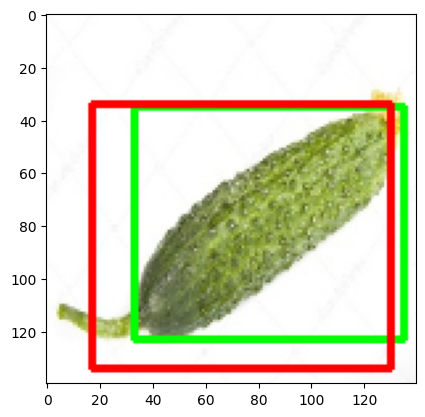

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():

    image,gt_bbox = validset[25] #(c, h ,w)
    image = image.unsqueeze(0).to(DEVICE) #(bs, c , h , w)
    out_bbox = model(image)

    utils.compare_plots(image, gt_bbox, out_bbox)